In [5]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path

# Fix module path for imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Imports
from src.accelerometer._02_preprocess import AccelerometerPreprocessor
from src.accelerometer.config import *
from src.accelerometer._01_get_data import DataLoader, MultiDataLoader

# Matplotlib settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 100

# Load both PD patient files (ON and OFF medication)
pd_off_file = DATA_DIR / "801_1_accelerometer.pkl"
pd_on_file = DATA_DIR / "801_2_accelerometer.pkl"

# Create separate preprocessor instances and store a copy of the raw data
preprocessor_off = AccelerometerPreprocessor([pd_off_file], sampling_freq=SAMPLING_FREQ)
preprocessor_on = AccelerometerPreprocessor([pd_on_file], sampling_freq=SAMPLING_FREQ)

raw_data_off = preprocessor_off.multi_data[0].copy()
raw_data_on = preprocessor_on.multi_data[0].copy()

fs = SAMPLING_FREQ

print("Setup complete. Raw data for ON and OFF medication loaded.")

Setup complete. Raw data for ON and OFF medication loaded.


In [ ]:
# Create fresh preprocessor instances to avoid modifying the raw data
temp_preprocessor_off = AccelerometerPreprocessor([pd_off_file], sampling_freq=fs)
temp_preprocessor_on = AccelerometerPreprocessor([pd_on_file], sampling_freq=fs)

# Run filtering on the fresh data
temp_preprocessor_off._remove_drift(window_size=DRIFT_WINDOW_SIZE)
temp_preprocessor_off._bandpass_filter(lowcut=BANDPASS_LOWCUT, highcut=BANDPASS_HIGHCUT, freq_resolution=BANDPASS_FREQ_RESOLUTION)
filtered_data_off = temp_preprocessor_off.multi_data[0]

temp_preprocessor_on._remove_drift(window_size=DRIFT_WINDOW_SIZE)
temp_preprocessor_on._bandpass_filter(lowcut=BANDPASS_LOWCUT, highcut=BANDPASS_HIGHCUT, freq_resolution=BANDPASS_FREQ_RESOLUTION)
filtered_data_on = temp_preprocessor_on.multi_data[0]

# Create a figure with 2 columns for ON and OFF
fig, axs = plt.subplots(3, 2, sharex=True, figsize=(16, 12))
fig.suptitle("Filtered vs Raw Time-Series", fontsize=20)

for col_idx, (raw_data, filtered_data, title) in enumerate([
    (raw_data_off, filtered_data_off, 'PD Patient (OFF Meds)'),
    (raw_data_on, filtered_data_on, 'PD Patient (ON Meds)')
]):
    timesteps = np.arange(raw_data.shape[1]) / fs
    for row_idx, axis_label in enumerate(['X', 'Y', 'Z']):
        axs[row_idx, col_idx].plot(timesteps, raw_data[row_idx], label='Raw', alpha=0.5)
        axs[row_idx, col_idx].plot(timesteps, filtered_data[row_idx], label='Filtered')
        
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(title)
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel(f"{axis_label}-axis (m/s²)")
        if row_idx == 2:
            axs[row_idx, col_idx].set_xlabel('Time (s)')

axs[0, 0].legend()
plt.tight_layout()
plt.show()

ValueError: The length of the input vector x must be greater than padlen, which is 150.

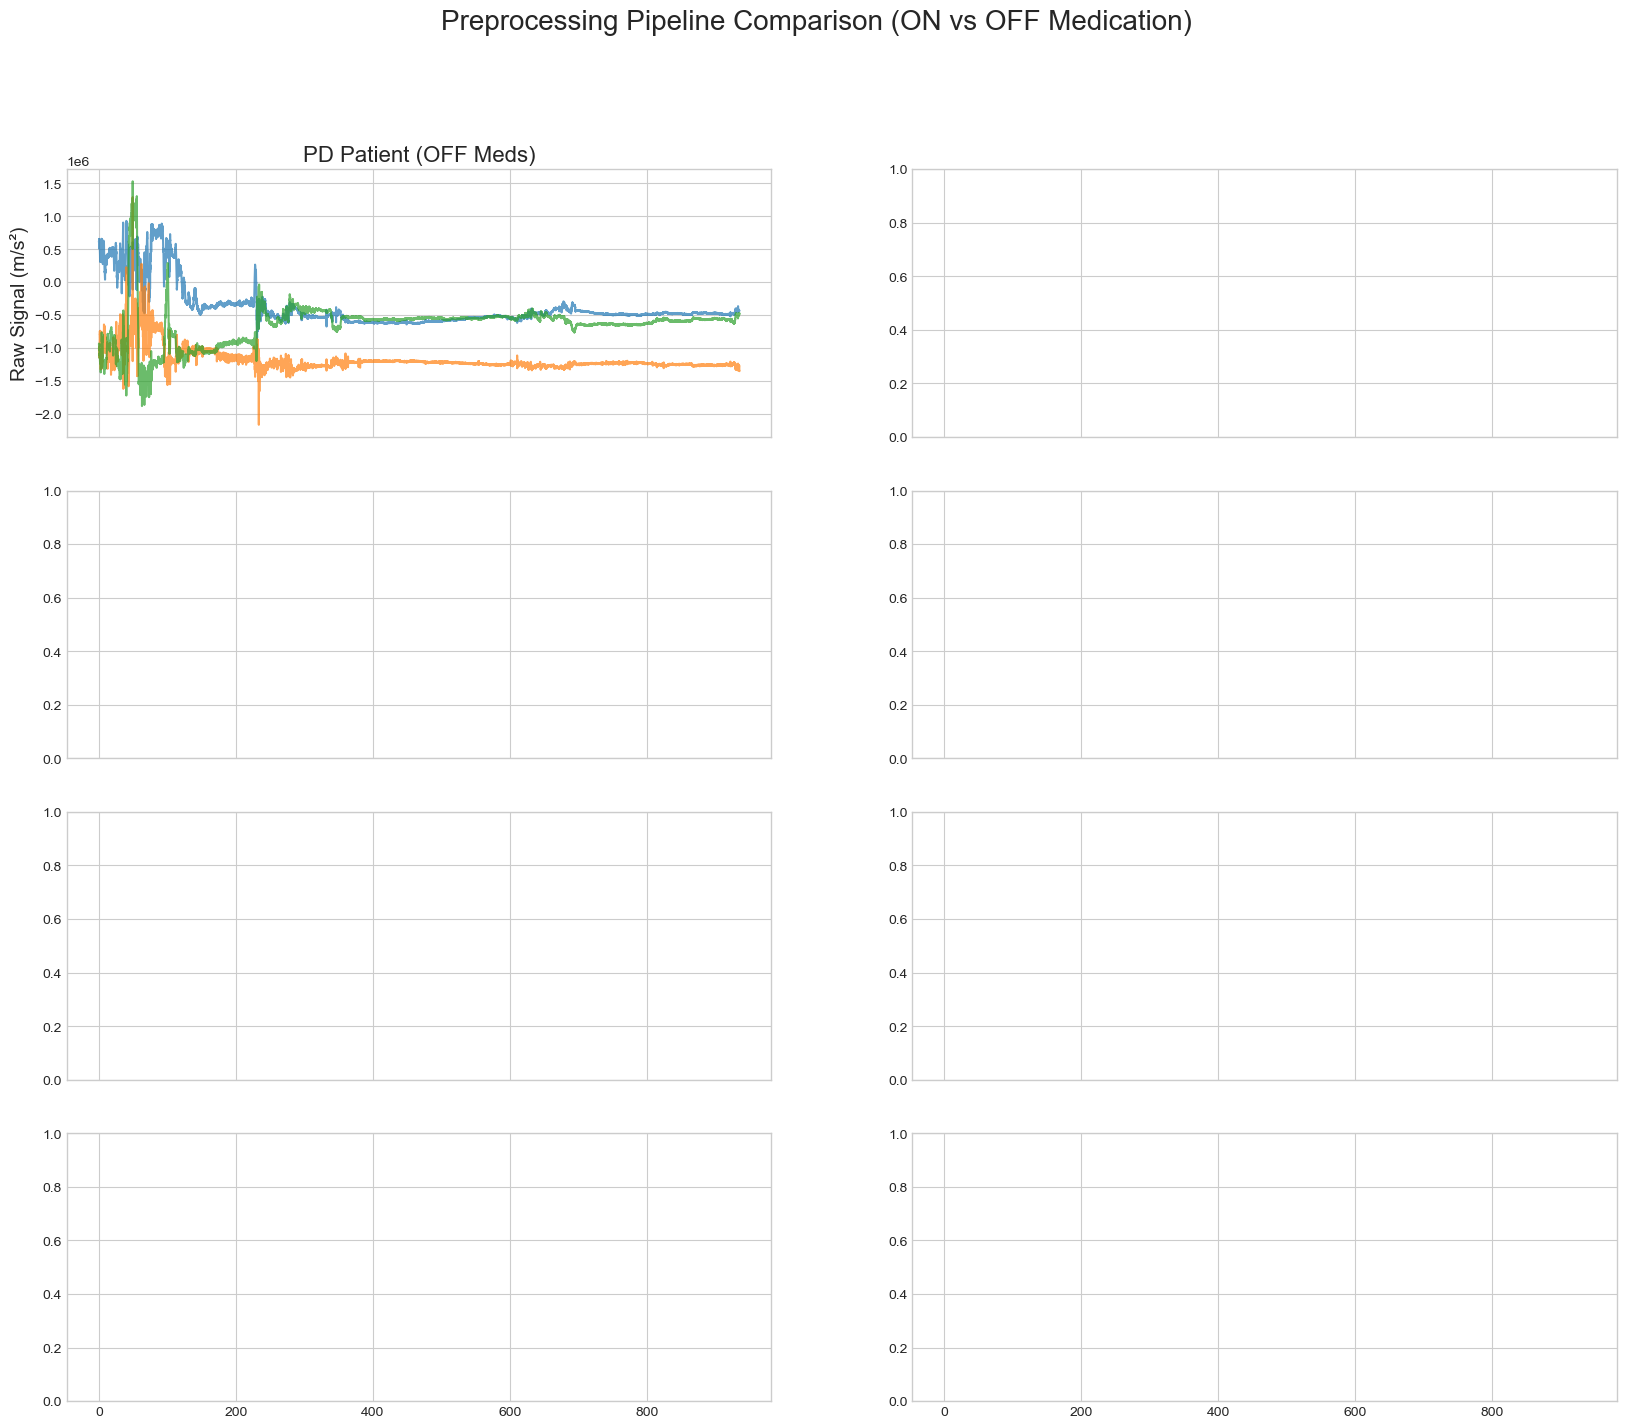

In [ ]:
segment_length_s = 3
segment_start_s = 60
segment_end_s = segment_start_s + segment_length_s

fig, axs = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(16, 12))
fig.suptitle(f"Hamming Window Application on a {segment_length_s}-second Segment", fontsize=20)

for col_idx, (raw_data, title) in enumerate([
    (raw_data_off, 'PD Patient (OFF Meds)'),
    (raw_data_on, 'PD Patient (ON Meds)')
]):
    start_idx = int(segment_start_s * fs)
    end_idx = int(segment_end_s * fs)
    segment_data = raw_data[:, start_idx:end_idx]
    
    hamming_window = np.hamming(segment_data.shape[1])
    windowed_segment = segment_data * hamming_window[np.newaxis, :]
    
    timesteps = np.arange(segment_data.shape[1]) / fs
    
    for row_idx, axis_label in enumerate(['X', 'Y', 'Z']):
        axs[row_idx, col_idx].plot(timesteps, segment_data[row_idx], label='Raw Segment', alpha=0.5)
        axs[row_idx, col_idx].plot(timesteps, windowed_segment[row_idx], label='Windowed Segment')
        
        if row_idx == 0:
            axs[row_idx, col_idx].set_title(title)
        if col_idx == 0:
            axs[row_idx, col_idx].set_ylabel(f"{axis_label}-axis (m/s²)")
        if row_idx == 2:
            axs[row_idx, col_idx].set_xlabel('Time (s)')

axs[0, 0].legend()
plt.tight_layout()
plt.show()